# **Document Summarizer- NLP**
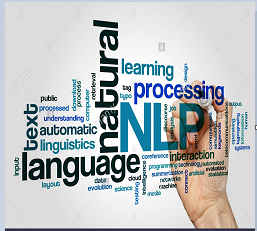


#### **Problem Statement**:
“I don’t want a full detail, just give me a summary of the context !!”. We may often found ourselves in this situation when we have no time to read the long paragraphs.
Manually converting the detail to a summarized version is some time taking, since it requires analysis. This is where "**Document/Text Summarization**" comes into picture and could really helps out.

#### **Dataset**:

The datasets we have used here are different news articles published by New York Times, Breitbart, CNN, Business Insider, The Atlantic, Fox News, Talking Points Memo, Buzzfeed News, National Review, New York Post, The Guardian, NPR, Reuters, Vox, and The Washington Post., 
Given 3 CSV documents articles1, articles2, articles3.

  *   articles1.csv - 50,000 news articles (1-50,000)

  *   articles2.csv - 49,999 news articles (50,001-100,00)

  *   articles3.csv - Articles 100,001+


#### **Objective**: 
Our goal is to: 

*   Generate Summaries and Word Cloud Arts for the articles.
*   Search 10 articles for the request and find similar articles using **TF-IDF**
*   Clustering "Bag of Words" and Predict the closest cluster each sample using **K-Means**

# **Mounting Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Importing the required Libraries**

In [ ]:
import numpy as np
import pandas as pd
import warnings
import re
import nltk
nltk.download('punkt')
from nltk import word_tokenize
from nltk.tokenize import sent_tokenize
!pip install textblob
from textblob import TextBlob
import string
from string import punctuation
punctuation = punctuation + '\n' + '—' + '“' + ',' + '”' + '‘' + '-' + '’'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from nltk.corpus import stopwords
!pip install statistics
from statistics import mean
from heapq import nlargest
!pip install wordcloud
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Importing the dataset
df_1 = pd.read_csv("/content/drive/My Drive/Convergence2020/articles1.csv")
df_2 = pd.read_csv("/content/drive/My Drive/Convergence2020/articles2.csv")
df_3 = pd.read_csv("/content/drive/My Drive/Convergence2020/articles3.csv")

In [ ]:
# Checking if the columns are same or not
df_1.columns == df_2.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [ ]:
# Checking if the columns are same or not
df_2.columns == df_3.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [ ]:
# Making one Dataframe by appending all of them for the further process
d = [df_1, df_2, df_3]
df = pd.concat(d, keys = ['x', 'y', 'z'])
df.rename(columns = {'content' : 'article'}, inplace = True);

In [ ]:
df.head(10)

Unnamed: 0     id  ...  url                                            article
x 0           0  17283  ...  NaN  WASHINGTON  —   Congressional Republicans have...
  1           1  17284  ...  NaN  After the bullet shells get counted, the blood...
  2           2  17285  ...  NaN  When Walt Disney’s “Bambi” opened in 1942, cri...
  3           3  17286  ...  NaN  Death may be the great equalizer, but it isn’t...
  4           4  17287  ...  NaN  SEOUL, South Korea  —   North Korea’s leader, ...
  5           5  17288  ...  NaN  LONDON  —   Queen Elizabeth II, who has been b...
  6           6  17289  ...  NaN  BEIJING  —   President Tsai   of Taiwan sharpl...
  7           7  17290  ...  NaN  Danny Cahill stood, slightly dazed, in a blizz...
  8           8  17291  ...  NaN  Just how   is Hillary Kerr, the    founder of ...
  9           9  17292  ...  NaN  Angels are everywhere in the Muñiz family’s ap...

[10 rows x 10 columns]

In [ ]:
# Shape of the dataset
print ("Shape of the dataset: ", df.shape)

Shape of the dataset:  (142570, 10)


In [ ]:
# Dropping the unnecessary columns
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

id  ...                                            article
x 0  17283  ...  WASHINGTON  —   Congressional Republicans have...
  1  17284  ...  After the bullet shells get counted, the blood...
  2  17285  ...  When Walt Disney’s “Bambi” opened in 1942, cri...
  3  17286  ...  Death may be the great equalizer, but it isn’t...
  4  17287  ...  SEOUL, South Korea  —   North Korea’s leader, ...

[5 rows x 9 columns]

Since the Content of the articles are in pandas series, we need to change them into a single string.

# **Exploratory Data Analysis**

In [ ]:
df.head()

id  ...                                            article
x 0  17283  ...  WASHINGTON  —   Congressional Republicans have...
  1  17284  ...  After the bullet shells get counted, the blood...
  2  17285  ...  When Walt Disney’s “Bambi” opened in 1942, cri...
  3  17286  ...  Death may be the great equalizer, but it isn’t...
  4  17287  ...  SEOUL, South Korea  —   North Korea’s leader, ...

[5 rows x 9 columns]

#### **Data Cleansing**

In [ ]:
## Replacing the unnecessary row value of year with it's actual values
df['year'] = df['year'].replace("https://www.washingtonpost.com/outlook/tale-of-a-woman-who-died-and-a-woman-who-killed-in-the-northern-ireland-conflict/2019/03/08/59e75dd4-2ecd-11e9-8ad3-9a5b113ecd3c_story.html", 2019)

In [ ]:
## Years
df['year'].value_counts()

2016.0    85405
2017.0    50404
2015.0     3705
2013.0      228
2014.0      125
2012.0       34
2011.0        8
2010.0        6
2009.0        3
2008.0        3
2005.0        2
2004.0        2
2003.0        2
2007.0        1
2000.0        1
Name: year, dtype: int64

#### **Distribution of articles across the years**

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Year'),
 Text(0.5, 1.0, 'Distribution of the articles across years')]

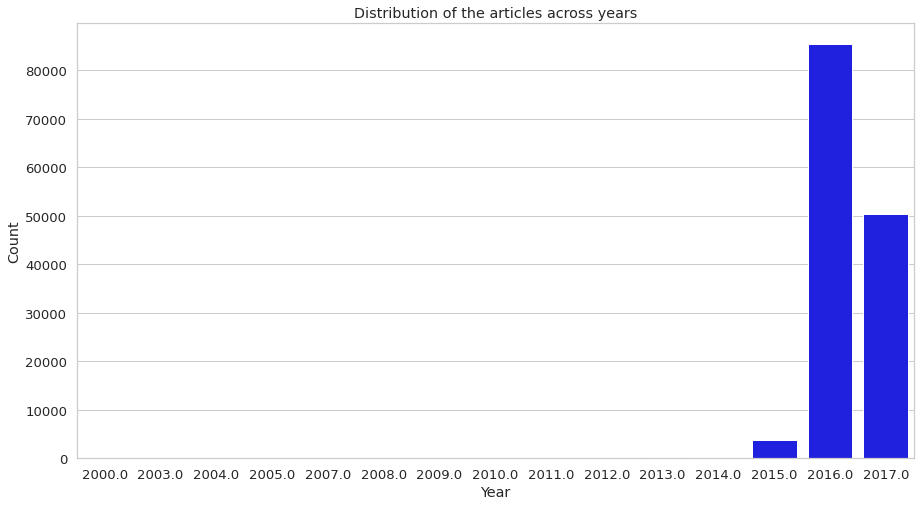

In [ ]:
## Countplot shows the distribution of the articles according to the year
plt.rcParams['figure.figsize'] = [15, 8]
sns.set(font_scale = 1.2, style = 'whitegrid')
sns_year = sns.countplot(df['year'], color = 'blue')
sns_year.set(xlabel = "Year", ylabel = "Count", title = "Distribution of the articles across years")

In [ ]:
# Authors
df['author'].value_counts()

Breitbart News                                       1559
Pam Key                                              1282
Associated Press                                     1231
Charlie Spiering                                      928
Jerome Hudson                                         806
                                                     ... 
Julia Marsh and Caroll Alvarado                         1
Christopher I. Haugh                                    1
Richard Fausset, Manny Fernandez and Alan Blinder       1
Sandra Hoyn                                             1
Ankit Ajmera and Denny Thomas                           1
Name: author, Length: 15647, dtype: int64

In [ ]:
# Changing the value "The Associated Press" to "Associated Press"
df['author'] = df['author'].replace("The Associated Press", "Associated Press")

In [ ]:
# Top 25 authors
df['author'].value_counts()[0:25]

Breitbart News          1559
Pam Key                 1282
Associated Press        1260
Charlie Spiering         928
Jerome Hudson            806
John Hayward             747
Daniel Nussbaum          735
AWR Hawkins              720
Ian Hanchett             647
Joel B. Pollak           624
Post Editorial Board     620
Alex Swoyer              604
Camila Domonoske         593
Warner Todd Huston       545
NPR Staff                514
Jeff Poor                505
Merrit Kennedy           484
Trent Baker              457
Breitbart London         447
Katherine Rodriguez      435
Reuters                  434
Charlie Nash             421
Bill Chappell            412
Ben Kew                  373
Frances Martel           366
Name: author, dtype: int64

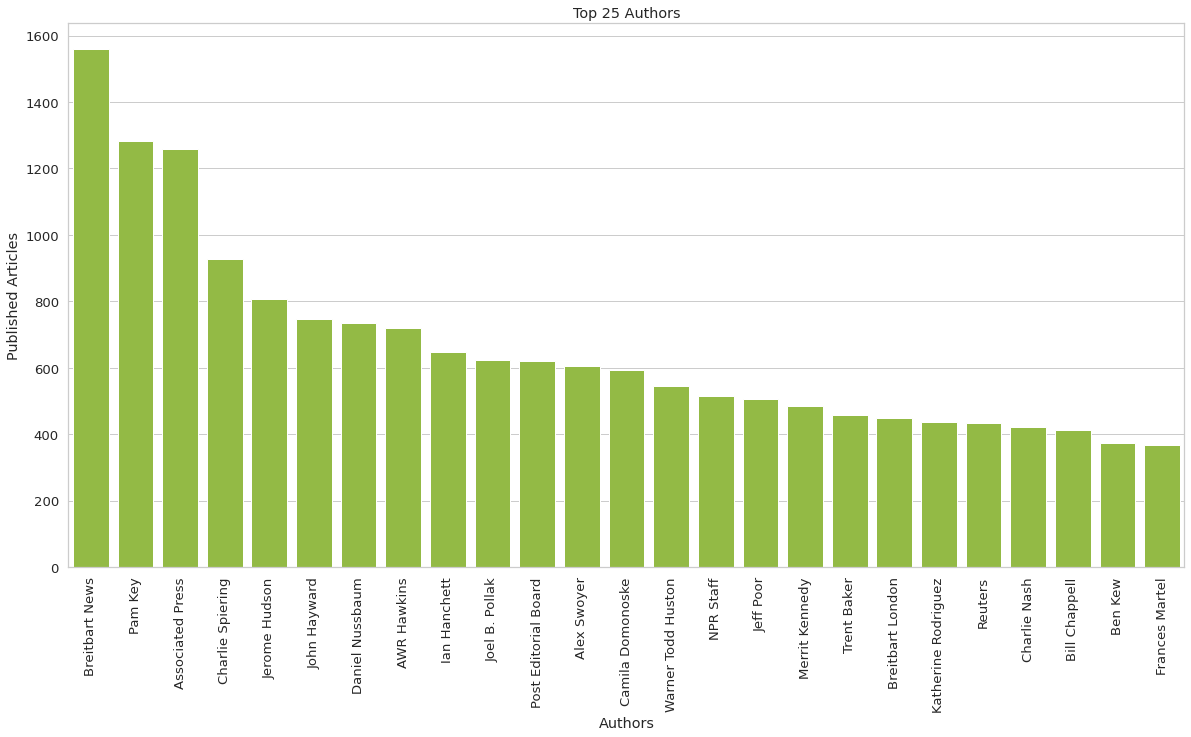

In [ ]:
# Barplot showing the top 25 Authors
plt.rcParams['figure.figsize'] = [20, 10]
author_count = df['author'].value_counts()[0:25]
top_25 = sns.barplot(x = list(author_count.index), y = (author_count.values), color = 'yellowgreen')
top_25.set(xlabel = "Authors", ylabel = "Published Articles", title = "Top 25 Authors")
plt.setp(top_25.get_xticklabels(), rotation = 90);

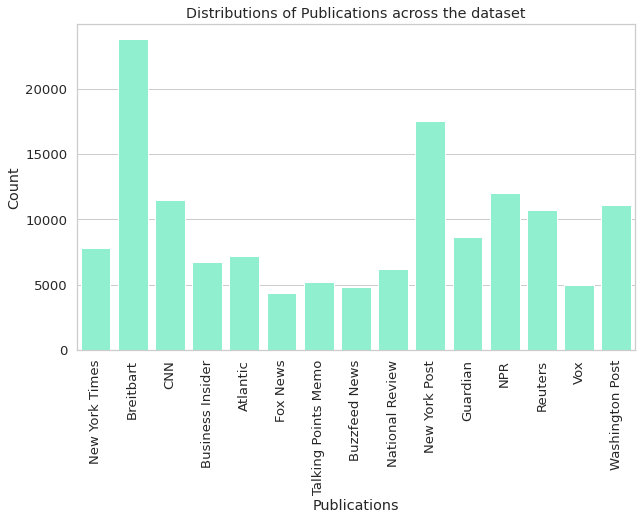

In [ ]:
# Countplot shows the distribution of different Publications
plt.rcParams['figure.figsize'] = [10, 6]
sns.set(font_scale = 1.2, style = 'whitegrid')
sns_pub = sns.countplot(df['publication'], color = 'aquamarine')
sns_pub.set(xlabel = "Publications", ylabel = "Count", title = "Distributions of Publications across the dataset")
plt.setp(sns_pub.get_xticklabels(), rotation = 90);

# **Data Preprocessing**

  Expand the contractions, Converting to lowercases, Removing stop words, HTML's, email id's, etc.,
  

#### **Define Contractions**

In [ ]:
contractions_dict = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"doesn’t": "does not",
"don't": "do not",
"don’t": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y’all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have",
"ain’t": "am not",
"aren’t": "are not",
"can’t": "cannot",
"can’t’ve": "cannot have",
"’cause": "because",
"could’ve": "could have",
"couldn’t": "could not",
"couldn’t’ve": "could not have",
"didn’t": "did not",
"doesn’t": "does not",
"don’t": "do not",
"don’t": "do not",
"hadn’t": "had not",
"hadn’t’ve": "had not have",
"hasn’t": "has not",
"haven’t": "have not",
"he’d": "he had",
"he’d’ve": "he would have",
"he’ll": "he will",
"he’ll’ve": "he will have",
"he’s": "he is",
"how’d": "how did",
"how’d’y": "how do you",
"how’ll": "how will",
"how’s": "how is",
"i’d": "i would",
"i’d’ve": "i would have",
"i’ll": "i will",
"i’ll’ve": "i will have",
"i’m": "i am",
"i’ve": "i have",
"isn’t": "is not",
"it’d": "it would",
"it’d’ve": "it would have",
"it’ll": "it will",
"it’ll’ve": "it will have",
"it’s": "it is",
"let’s": "let us",
"ma’am": "madam",
"mayn’t": "may not",
"might’ve": "might have",
"mightn’t": "might not",
"mightn’t’ve": "might not have",
"must’ve": "must have",
"mustn’t": "must not",
"mustn’t’ve": "must not have",
"needn’t": "need not",
"needn’t’ve": "need not have",
"o’clock": "of the clock",
"oughtn’t": "ought not",
"oughtn’t’ve": "ought not have",
"shan’t": "shall not",
"sha’n’t": "shall not",
"shan’t’ve": "shall not have",
"she’d": "she would",
"she’d’ve": "she would have",
"she’ll": "she will",
"she’ll’ve": "she will have",
"she’s": "she is",
"should’ve": "should have",
"shouldn’t": "should not",
"shouldn’t’ve": "should not have",
"so’ve": "so have",
"so’s": "so is",
"that’d": "that would",
"that’d’ve": "that would have",
"that’s": "that is",
"there’d": "there would",
"there’d’ve": "there would have",
"there’s": "there is",
"they’d": "they would",
"they’d’ve": "they would have",
"they’ll": "they will",
"they’ll’ve": "they will have",
"they’re": "they are",
"they’ve": "they have",
"to’ve": "to have",
"wasn’t": "was not",
"we’d": "we would",
"we’d’ve": "we would have",
"we’ll": "we will",
"we’ll’ve": "we will have",
"we’re": "we are",
"we’ve": "we have",
"weren’t": "were not",
"what’ll": "what will",
"what’ll’ve": "what will have",
"what’re": "what are",
"what’s": "what is",
"what’ve": "what have",
"when’s": "when is",
"when’ve": "when have",
"where’d": "where did",
"where’s": "where is",
"where’ve": "where have",
"who’ll": "who will",
"who’ll’ve": "who will have",
"who’s": "who is",
"who’ve": "who have",
"why’s": "why is",
"why’ve": "why have",
"will’ve": "will have",
"won’t": "will not",
"won’t’ve": "will not have",
"would’ve": "would have",
"wouldn’t": "would not",
"wouldn’t’ve": "would not have",
"y’all": "you all",
"y’all": "you all",
"y’all’d": "you all would",
"y’all’d’ve": "you all would have",
"y’all’re": "you all are",
"y’all’ve": "you all have",
"you’d": "you would",
"you’d’ve": "you would have",
"you’ll": "you will",
"you’ll’ve": "you will have",
"you’re": "you are",
"you’re": "you are",
"you’ve": "you have",
}
contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

In [ ]:
# Function to clean the html from the article
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

In [ ]:
# Function expand the contractions if there's any
def expand_contractions(s, contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, s)

In [ ]:
# Function to preprocess the articles
def preprocessing(article):
    global article_sent
    
    # Converting to lowercase
    article = article.str.lower()
    
    # Removing the HTML
    article = article.apply(lambda x: cleanhtml(x))
    
    # Removing the email ids
    article = article.apply(lambda x: re.sub('\S+@\S+','', x))
    
    # Removing The URLS
    article = article.apply(lambda x: re.sub("((http\://|https\://|ftp\://)|(www.))+(([a-zA-Z0-9\.-]+\.[a-zA-Z]{2,4})|([0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}))(/[a-zA-Z0-9%:/-_\?\.'~]*)?",'', x))
    
    # Removing the '\xa0'
    article = article.apply(lambda x: x.replace("\xa0", " "))
    
    # Removing the contractions
    article = article.apply(lambda x: expand_contractions(x))
    
    # Stripping the possessives
    article = article.apply(lambda x: x.replace("'s", ''))
    article = article.apply(lambda x: x.replace('’s', ''))
    article = article.apply(lambda x: x.replace("\'s", ''))
    article = article.apply(lambda x: x.replace("\’s", ''))
    
    # Removing the Trailing and leading whitespace and double spaces
    article = article.apply(lambda x: re.sub(' +', ' ',x))
    
    # Copying the article for the sentence tokenization
    article_sent = article.copy()
    
    # Removing punctuations from the article
    article = article.apply(lambda x: ''.join(word for word in x if word not in punctuation))
    
    # Removing the Trailing and leading whitespace and double spaces again as removing punctuation might
    # Lead to a white space
    article = article.apply(lambda x: re.sub(' +', ' ',x))
    
    # Removing the Stopwords
    article = article.apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))
    
    return article

In [ ]:
# Function to normalize the word frequency which is used in the function word_frequency
def normalize(li_word):
    global normalized_freq
    normalized_freq = []
    for dictionary in li_word:
        max_frequency = max(dictionary.values())
        for word in dictionary.keys():
            dictionary[word] = dictionary[word]/max_frequency
        normalized_freq.append(dictionary)
    return normalized_freq

In [ ]:
# Function to calculate the word frequency
def word_frequency(article_word):
    word_frequency = {}
    li_word = []
    for sentence in article_word:
        for word in word_tokenize(sentence):
            if word not in word_frequency.keys():
                word_frequency[word] = 1
            else:
                word_frequency[word] += 1
        li_word.append(word_frequency)
        word_frequency = {}
    normalize(li_word)
    return normalized_freq

In [ ]:
# Function to Score the sentence which is called in the function sent_token
def sentence_score(li):
    global sentence_score_list
    sentence_score = {}
    sentence_score_list = []
    for list_, dictionary in zip(li, normalized_freq):
        for sent in list_:
            for word in word_tokenize(sent):
                if word in dictionary.keys():
                    if sent not in sentence_score.keys():
                        sentence_score[sent] = dictionary[word]
                    else:
                        sentence_score[sent] += dictionary[word]
        sentence_score_list.append(sentence_score)
        sentence_score = {}
    return sentence_score_list

In [ ]:
# Function to tokenize the sentence
def sent_token(article_sent):
    sentence_list = []
    sent_token = []
    for sent in article_sent:
        token = sent_tokenize(sent)
        for sentence in token:
            token_2 = ''.join(word for word in sentence if word not in punctuation)
            token_2 = re.sub(' +', ' ',token_2)
            sent_token.append(token_2)
        sentence_list.append(sent_token)
        sent_token = []
    sentence_score(sentence_list)
    return sentence_score_list

In [ ]:
# Function which generates the summary of the articles (This uses the 20% of the sentences with the highest score)
def summary(sentence_score_OwO):
    summary_list = []
    for summ in sentence_score_OwO:
        select_length = int(len(summ)*0.25)
        summary_ = nlargest(select_length, summ, key = summ.get)
        summary_list.append(".".join(summary_))
    return summary_list

In [ ]:
# Functions to change the article string (if passed) to change it to generate a pandas series
def make_series(art):
    global dataframe
    data_dict = {'article' : [art]}
    dataframe = pd.DataFrame(data_dict)['article']
    return dataframe

In [ ]:
# Function which is to be called to generate the summary which in further calls other functions alltogether
def article_summarize(artefact):
    
    if type(artefact) != pd.Series:
        artefact = make_series(artefact)
    
    df = preprocessing(artefact)
    
    word_normalization = word_frequency(df)
    
    sentence_score_OwO = sent_token(article_sent)
    
    summarized_article = summary(sentence_score_OwO)
    
    return summarized_article

In [ ]:
# Generating the Word Cloud art for articles (using the preprocessing and make_series function mentioned below)
def word_cloud(art):
    art_ = make_series(art)
    OwO = preprocessing(art_)
    wordcloud_ = WordCloud(height = 500, width = 1000, background_color = 'white').generate(art)
    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud_, interpolation='bilinear')
    plt.axis('off');

# **Generating Summaries for 100 articles**

#### **Checking Summaries and Word Clouds for 1st, 25th, 50th, 75th and 100th articles**

In [ ]:
# Generating the summaries for the first 100 articles
summaries = article_summarize(df['article'][0:100])

In [ ]:
print ("The Actual length of 1st article is : ", len(df['article'][0]))
print('\n',df['article'][0])
print ("\n\n The length of 1st summarized article is : ", len(summaries[0]))
summaries[0]

The Actual length of 1st article is :  5607

 WASHINGTON  —   Congressional Republicans have a new fear when it comes to their    health care lawsuit against the Obama administration: They might win. The incoming Trump administration could choose to no longer defend the executive branch against the suit, which challenges the administration’s authority to spend billions of dollars on health insurance subsidies for   and   Americans, handing House Republicans a big victory on    issues. But a sudden loss of the disputed subsidies could conceivably cause the health care program to implode, leaving millions of people without access to health insurance before Republicans have prepared a replacement. That could lead to chaos in the insurance market and spur a political backlash just as Republicans gain full control of the government. To stave off that outcome, Republicans could find themselves in the awkward position of appropriating huge sums to temporarily prop up the Obama health care law

'anticipating that the trump administration might not be inclined to mount a vigorous fight against the house republicans given the dim view of the health care law a team of lawyers this month sought to intervene in the case on behalf of two participants in the health care program.the incoming trump administration could choose to no longer defend the executive branch against the suit which challenges the administration authority to spend billions of dollars on health insurance subsidies for and americans handing house republicans a big victory on issues. in a potentially decision in 2015 judge rosemary m collyer ruled that house republicans had the standing to sue the executive branch over a spending dispute and that the obama administration had been distributing the health insurance subsidies in violation of the constitution without approval from congress.in their request the lawyers predicted that a deal between house republicans and the new administration to dismiss or settle the ca

Word cloud for 1st Article:



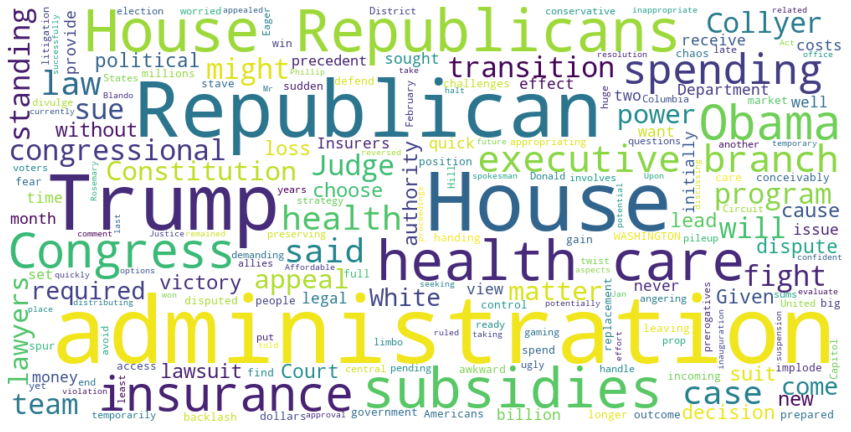

In [ ]:
print('Word cloud for 1st Article:\n')
word_cloud(df['article'][0])

In [ ]:
print ("The Actual length of 25th article is : ", len(df['article'][24]))
print('\n',df['article'][24])
print ("\n\n The length of 25th summarized article is : ", len(summaries[24]))
summaries[24]

The Actual length of 25th article is :  7997

 WASHINGTON  —   The most powerful and ambitious   Congress in 20 years will convene Tuesday, with plans to leave its mark on virtually every facet of American life  —   refashioning the country’s social safety net, wiping out scores of labor and environmental regulations and unraveling some of the most significant policy prescriptions put forward by the Obama administration. Even before   Donald J. Trump is sworn in on Jan. 20, giving their party full control of the government, Republicans plan quick action on several of their top priorities  —   most notably a measure to clear a path for the Affordable Care Act’s repeal. Perhaps the first thing that will happen in the new Congress is the push for deregulation. Also up early: filling a   Supreme Court seat, which is sure to set off a pitched showdown, and starting confirmation hearings for Mr. Trump’s cabinet nominees. “It’s a big job to actually have responsibility and produce results,” s

'but on many issues senate democrats including their new leader chuck schumer of new york are expected to pivot from postelection carping to active thwarting using complex senate procedures and political messaging to slow or perhaps block elements of mr trump agenda.republicans have been particularly upset that senator jeff sessions of alabama whom mr trump picked quickly to be attorney general has either not gotten meetings with democrats on the senate judiciary committee or had meetings canceled.the senate must also consider mr trump cabinet picks and senate democrats are already trying to slow the process.speaker newt gingrich took control with a determined agenda only to be stymied by the senate majority leader bob dole who stacked conservative house bills like so many fire logs in the back of the senate chamber.even before donald j trump is sworn in on jan 20 giving their party full control of the government republicans plan quick action on several of their top priorities most not

Word cloud for 25th Article:



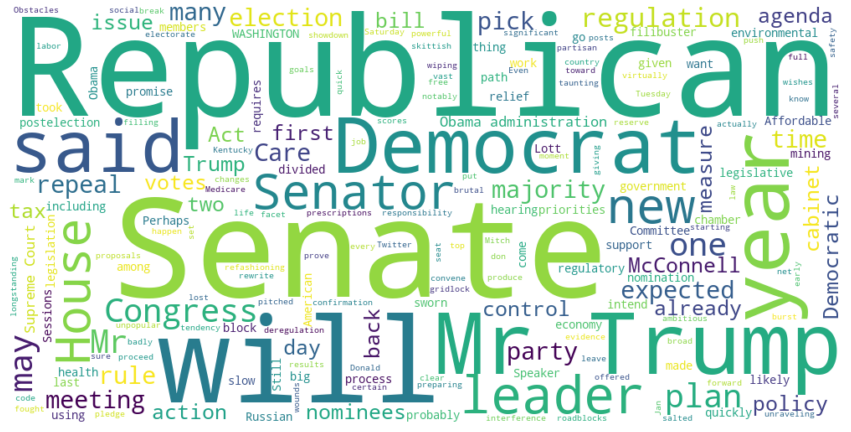

In [ ]:
print('Word cloud for 25th Article:\n')
word_cloud(df['article'][24])

In [ ]:
print ("The Actual length of 50th article is : ", len(df['article'][49]))
print('\n',df['article'][49])
print ("\n\n The length of 50th summarized article is : ", len(summaries[49]))
summaries[49]

The Actual length of 50th article is :  6232

 Megyn Kelly’s new office at NBC News sits a block north of Fox News headquarters in Midtown Manhattan. But it might as well be a world away. In switching networks at a pivotal point in her career, Ms. Kelly, the No.   personality in cable television news, is taking a calculated risk that she can swap her dedicated Fox audience for the broader, but more fickle, viewership of network television. There are challenges from the  . Her splashy arrival has the potential to fray nerves among the big personalities at the network  —   who already compete against one another for interviews and scoops. Ms. Kelly, 46, will also be taking on a daytime talk show format that has been a virtual graveyard for television news personalities in the last 10 years. And the new Sunday newsmagazine show that NBC plans to build around Ms. Kelly will go up against a giant that has not been meaningfully challenged for decades: “60 Minutes” on CBS. Still, Ms. Kelly is

'nbc said on tuesday that ms kelly show was expected to be closer to a news program than the typical daytime talk show although it is unclear what exactly that will mean or how much appetite there is for news amid a landscape including shows like days of our lives the ellen degeneres show and steve harvey.potential replacements being floated inside the network on tuesday include four women who have regularly filled in for ms kelly sandra smith a host of fox noon show outnumbered trish regan a rising star at fox business network shannon bream who covers the supreme court and martha maccallum a morning anchor.ms kelly exit from fox news was so abrupt that it was announced on the day that the network had run a ad in the wall street journal trumpeting the ratings of its lineup with ms kelly prominently pictured.her departure stunned the fox newsroom where journalists and executives spent tuesday afternoon speculating over which anchor might replace ms kelly in the coveted 9 p m slot and wo

Word cloud for 50th Article:



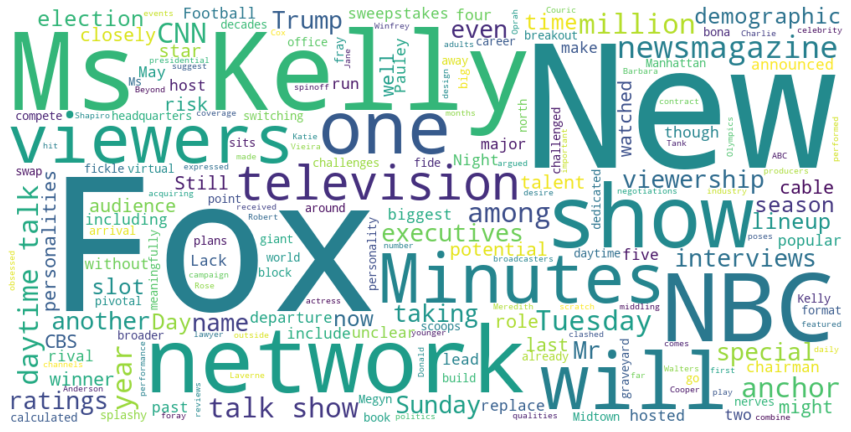

In [ ]:
print('Word cloud for 50th Article:\n')
word_cloud(df['article'][49])

In [ ]:
print ("The Actual length of 75th article is : ", len(df['article'][74]))
print('\n',df['article'][74])
print ("\n \n The length of 75th summarized article is : ", len(summaries[74]))
summaries[74]

The Actual length of 75th article is :  5570

 WASHINGTON  —   Federal Reserve officials expect Donald J. Trump’s election to result in somewhat faster economic growth over the next several years, but they see little chance of the boom Mr. Trump has promised, according to an account of the Fed’s most recent meeting in  . That is in part because the Fed plans to raise interest rates more quickly if growth accelerates. For now, however, Fed officials plan to wait and see what happens next, the account said. “While the Fed signaled that it would likely respond to expansionary fiscal policies with a faster pace of rate hikes, the Fed believes it is too early to embed this into its baseline,” Michael Gapen, chief United States economist at Barclays, wrote on Wednesday following the release of the minutes. “Any real shift in the stance of monetary policy will require more clarity on the stance of fiscal policy. ” At the December meeting, the Fed raised its benchmark rate for just the second 

'washington federal reserve officials expect donald j trump election to result in somewhat faster economic growth over the next several years but they see little chance of the boom mr trump has promised according to an account of the fed most recent meeting in .as a result the account said fed officials regard both faster growth and slower growth as more likely than before the election when the economy seemed locked into its longstanding pattern of slow and steady growth.while the fed signaled that it would likely respond to expansionary fiscal policies with a faster pace of rate hikes the fed believes it is too early to embed this into its baseline michael gapen chief united states economist at barclays wrote on wednesday following the release of the minutes.the economic forecast prepared by the fed staff for the december meeting anticipated that mr trump election would result in slightly higher growth over the next several years.the account said officials were not yet ready to predic

Word cloud for 75th Article:



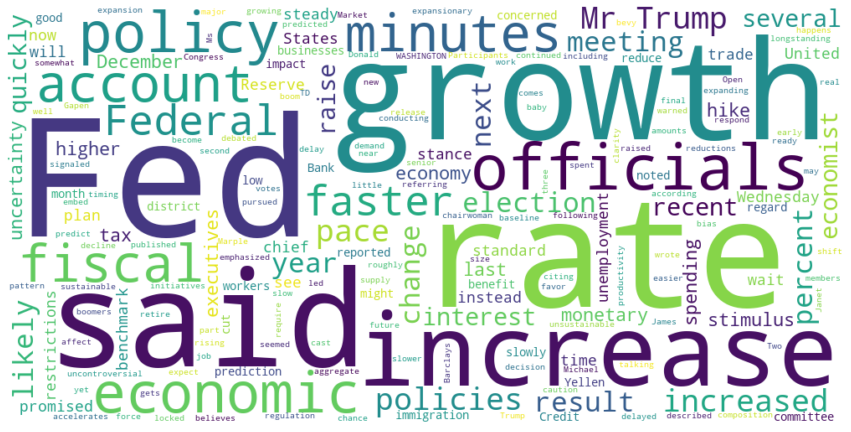

In [ ]:
print('Word cloud for 75th Article:\n')
word_cloud(df['article'][74])

In [ ]:
print ("The Actual length of 100th article is : ", len(df['article'][99]))
print('\n',df['article'][99])
print ("\n \n The length of 100th summarized article is : ", len(summaries[99]))
summaries[99]

The Actual length of 100th article is :  2967

 Struggling with sagging sales over another crucial holiday shopping season, Macy’s announced on Wednesday that it was eliminating more than 10, 000 jobs as part of a continuing plan to cut costs and close 100 stores. Macy’s, the country’s largest department store chain, said sales at its stores had fallen 2. 1 percent in November and December compared with the same period in 2015. Terry J. Lundgren, the company’s chairman and chief executive, said in a statement that while the trend was “consistent with the lower end of our guidance, we had anticipated sales would be stronger. ” He attributed the decline to “broader challenges” facing much of the retail industry. Consumers, who endured a long recession, have turned to   chains like T. J. Maxx and shifted their spending away from    stores for the convenience of online shopping with the retail giant Amazon. The announcement on Wednesday continued a trend for Macy’s, which announced last Ja

'the company estimated that the changes would save about 550 million a year starting in 2017 mr lundgren said the company was closing stores that were unproductive or are no longer robust shopping destinations because of changes in the local retail shopping landscape.struggling with sagging sales over another crucial holiday shopping season macy announced on wednesday that it was eliminating more than 10 000 jobs as part of a continuing plan to cut costs and close 100 stores.stores at the marketplace mall in rochester at the oakdale mall in johnson city n y near binghamton and at the preakness shopping center in wayne n j will close the company said.1 percent in november and december compared with the same period in 2015 terry j lundgren the company chairman and chief executive said in a statement that while the trend was consistent with the lower end of our guidance we had anticipated sales would be stronger.macy the country largest department store chain said sales at its stores had 

Word cloud for 100th Article:



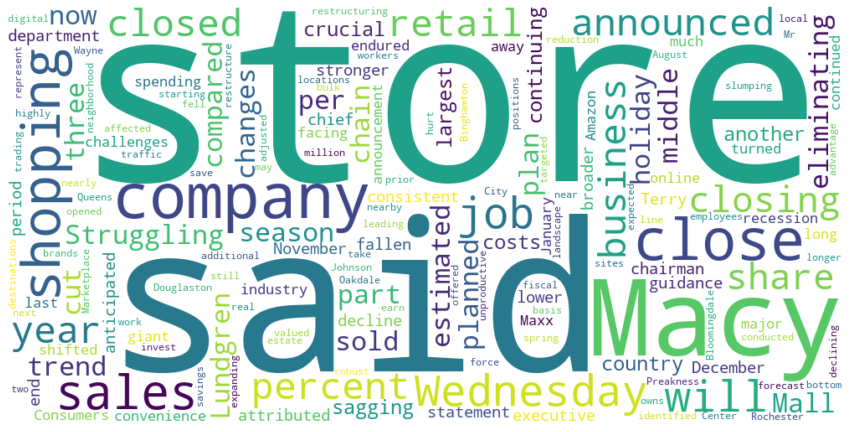

In [ ]:
print('Word cloud for 100th Article:\n')
word_cloud(df['article'][99])

# **Modelling**

In [ ]:
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import MiniBatchKMeans

In [ ]:
# Read the article1
X = pd.read_csv("/content/drive/My Drive/Convergence2020/articles1.csv")
X = X[pd.isna(X['title'])==False]
X = X[pd.isna(X['content'])==False]

In [ ]:
# Preview the data
X.head(3)

,Unnamed: 0,id,title,publication,author,date,year,month,url,content
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   50000 non-null  int64  
 1   id           50000 non-null  int64  
 2   title        50000 non-null  object 
 3   publication  50000 non-null  object 
 4   author       43694 non-null  object 
 5   date         50000 non-null  object 
 6   year         50000 non-null  float64
 7   month        50000 non-null  float64
 8   url          0 non-null      float64
 9   content      50000 non-null  object 
dtypes: float64(3), int64(2), object(5)
memory usage: 4.2+ MB


**Assessing word relevancy via term frequency-inverse document frequency**

The tf-idf is the product of the term frequency and the inverse document frequency:

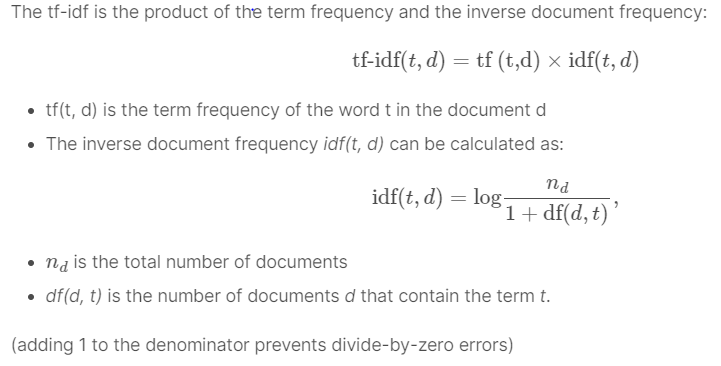

Scikit-learn implements the TfidfVectorizer, that takes 1d array of texts as input and transforms them into tf-idfs:

In [ ]:
# TF-IDF calculation
text_content = X['content']
vector = TfidfVectorizer(max_df=0.3,         # drop words that occur in more than X percent of documents
                             #min_df=8,      # only use words that appear at least X times
                             stop_words='english', # remove stop words
                             lowercase=True, # Convert everything to lower case 
                             use_idf=True,   # Use idf
                             norm=u'l2',     # Normalization
                             smooth_idf=True # Prevents divide-by-zero errors
                            )
tfidf = vector.fit_transform(text_content)

**Search Functions**

In [ ]:
# Request function : search the top_n articles from a request ( request = string)
def search(tfidf_matrix,model,request, top_n = 10):
    request_transform = model.transform([request])
    similarity = np.dot(request_transform,np.transpose(tfidf_matrix))
    x = np.array(similarity.toarray()[0])
    indices=np.argsort(x)[-10:][::-1]
    return indices

**Similar Function**

In [ ]:
# Find similar : get the top_n articles similar to an article 
def find_similar(tfidf_matrix, index, top_n = 10):
    cosine_similarities = linear_kernel(tfidf_matrix[index:index+1], tfidf_matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    return [index for index in related_docs_indices][0:top_n]

In [ ]:
# Print the result
def print_result(request_content,indices,X):
    print('\nsearch : ' + request_content)
    print('\nBest Results :')
    for i in indices:
        print('id = {0:10d} - title = {1}'.format(i,X['title'].loc[i]))

**Search Top 10 articles for request**

In [ ]:
request = 'peillon macron fillon marche'
#request = text_content[0]

result = search(tfidf,vector, request, top_n = 10)
print_result(request,result,X)


search : peillon macron fillon marche

Best Results :
id =      13084 - title = Accusations of Anti-Semitism Taint French Presidential Race
id =      44693 - title = Meet Emmanuel Macron, the 39-year-old former investment banker who will be the next French president
id =        590 - title = François Fillon, French Presidential Hopeful, Faces Inquiry Over Payments to Wife - The New York Times
id =       1791 - title = François Fillon, French Presidential Candidate, Is Charged With Embezzlement - The New York Times
id =      34493 - title = Emmanuel Macron’s tricky to-do list after French election
id =      34436 - title = France: Emmanuel Macron’s presidential campaign hacked
id =      33144 - title = Party leaders to weigh ’exit plan’ for embattled Fillon
id =       9102 - title = French Election: Fillon’s Fate Hinges on Paris Rally
id =      34487 - title = Emmanuel Macron: From political novice to president 
id =       1466 - title = François Fillon, French Presidential Candidate, 

**Find Similar articles to Titles**

### id= 13084:

In [ ]:
index = 13084
result = find_similar(tfidf, index, top_n = 10)
print_result('13084 - title = Accusations of Anti-Semitism Taint French Presidential Race',result,X)


search : 13084 - title = Accusations of Anti-Semitism Taint French Presidential Race

Best Results :
id =      34339 - title = French election: Is it Emmanuel Macron’s to lose?
id =      34436 - title = France: Emmanuel Macron’s presidential campaign hacked
id =      35546 - title = Macron on course for majority in French parliament 
id =      44693 - title = Meet Emmanuel Macron, the 39-year-old former investment banker who will be the next French president
id =      35361 - title = Macron on track for huge parliamentary majority
id =      34493 - title = Emmanuel Macron’s tricky to-do list after French election
id =      14375 - title = Macron Against Arresting and Deporting Radical Islamists
id =      34487 - title = Emmanuel Macron: From political novice to president 
id =      44689 - title = Emmanuel Macron wins French presidential election in landslide
id =      34479 - title = French election results: Macron defeats Le Pen


### id = 44693:

In [ ]:
index = 44693
result = find_similar(tfidf, index, top_n = 10)
print_result('13084 - title = Meet Emmanuel Macron, the 39-year-old former investment banker who will be the next French president',result,X)


search : 13084 - title = Meet Emmanuel Macron, the 39-year-old former investment banker who will be the next French president

Best Results :
id =      34487 - title = Emmanuel Macron: From political novice to president 
id =      34493 - title = Emmanuel Macron’s tricky to-do list after French election
id =      44689 - title = Emmanuel Macron wins French presidential election in landslide
id =      34479 - title = French election results: Macron defeats Le Pen
id =      45011 - title = French president excoriates Trump in English over his withdrawal from climate deal
id =      34436 - title = France: Emmanuel Macron’s presidential campaign hacked
id =      34339 - title = French election: Is it Emmanuel Macron’s to lose?
id =      11144 - title = Emmanuel Macron Inaugurated as France’s New President - Breitbart
id =      10383 - title = Delingpole: Manchurian Candidate Macron Is France’s Obama
id =       8566 - title = Macron to Lobby for Closer EU Integration on First Day as Presid

# **Clustering Corpus of Texts( using K-Means)**

In [ ]:
# Finding 10 clusters
k = 10
kmeans = MiniBatchKMeans(n_clusters = k)
kmeans.fit(tfidf)
cluster_centers = kmeans.cluster_centers_.argsort()[:,::-1]
terms = vector.get_feature_names()

**Bag of Words representing the center of each cluster**

In [ ]:
# centers of the clusters
for i in range(0,k):
    word_list=[]
    print("Cluster %d:"% i)
    for j in cluster_centers[i,:10]:
        word_list.append(terms[j])
    print(word_list)
    print('\n') 

Cluster 0:
['detroit', 'lights', 'city', 'streetlights', 'bartell', 'lighting', 'buses', 'kuzzo', 'livernois', 'pie']


Cluster 1:
['johnson', 'wrestling', 'dwayne', 'gq', 'rock', 'hollywood', 'moviefone', 'surely', 'therock', 'jumanji']


Cluster 2:
['isis', 'syria', 'syrian', 'islamic', 'iraq', 'forces', 'military', 'assad', 'attack', 'russia']


Cluster 3:
['mr', 'house', 'ryan', 'republicans', 'senate', 'obamacare', 'republican', 'democrats', 'health', 'care']


Cluster 4:
['mr', 'breitbart', 'obama', 'cnn', 'world', 'states', 'think', 'company', 'united', 'going']


Cluster 5:
['venezuela', 'maduro', 'venezuelan', 'opposition', 'reserves', 'oil', 'crisis', 'venezuelans', 'government', 'shortages']


Cluster 6:
['cruz', 'rubio', 'percent', 'ted', 'republican', 'kasich', 'voters', 'delegates', 'poll', 'gop']


Cluster 7:
['clinton', 'hillary', 'campaign', 'sanders', 'democratic', 'presidential', 'obama', 'mrs', 'emails', 'nominee']


Cluster 8:
['police', 'officers', 'officer', 'bla

# **Prediction**

In [ ]:
# Predict the closest cluster each sample in request_transform belongs to
request_transform = vector.transform(
    ["Accurate predictions of Earth’s warming require computers that are too expensive for one country or institution"])
kmeans.predict(request_transform)

array([4], dtype=int32)

In [ ]:
# Predict the closest cluster each sample in request_transform belongs to
request_transform = vector.transform(
    ["Automatic Text Summarization is one of the most challenging and interesting problems in the field of Natural Language Processing"])
kmeans.predict(request_transform)

array([4], dtype=int32)

**Inference**:
In the vector quantization literature, cluster_centers is called the **Code Book** and the value "4" returned by predict is the index of the closest code in the code book ie., cluster 4 is the closest for the given request_transform.